In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from collections import Counter
import matplotlib.pyplot as plt
import re
import numpy as np
import os

# Transactions

Intrinsic

In [26]:
intr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_intrinsic_scores_kgrid_test.csv")

In [27]:
display(intr)

,label_col,min_samples,eps_value,core_size,n_clusters,coverage,silhouette_core,davies_bouldin_core,calinski_harabasz_core
0,dbscan_ms5_p70_eps_0.416885,5,0.416885,175489,17,0.850027,-0.212574,2.029125,2.255057
1,dbscan_ms5_p80_eps_0.436465,5,0.436465,191559,7,0.927867,-0.189756,1.947166,1.629166
2,dbscan_ms5_p85_eps_0.446631,5,0.446631,197301,4,0.955680,-0.174542,1.672552,1.113602
3,dbscan_ms5_p90_eps_0.458462,5,0.458462,201721,1,0.977089,NaN,NaN,NaN
4,dbscan_ms5_p95_eps_0.473889,5,0.473889,204758,1,0.991800,NaN,NaN,NaN
5,dbscan_ms10_p70_eps_0.439453,10,0.439453,189176,2,0.916324,-0.104762,1.081868,0.808040
6,dbscan_ms10_p80_eps_0.458728,10,0.458728,200113,1,0.969300,NaN,NaN,NaN
7,dbscan_ms10_p85_eps_0.468802,10,0.468802,203193,1,0.984219,NaN,NaN,NaN
8,dbscan_ms10_p90_eps_0.480132,10,0.480132,205131,1,0.993606,NaN,NaN,NaN
9,dbscan_ms10_p95_eps_0.495112,10,0.495112,206130,1,0.998445,NaN,NaN,NaN


In [28]:
eps_col = "eps_value" if "eps_value" in intr.columns else "eps"

has_ms = "min_samples" in intr.columns and intr["min_samples"].notna().any()
groups = intr.groupby("min_samples") if has_ms else [(None, intr)]

In [29]:
def minmax(x):
    x = x.astype(float)
    r = x.max() - x.min()
    return (x - x.min())/r if r != 0 else pd.Series(np.zeros_like(x), index=x.index)

intr["sil_norm"] = minmax(intr["silhouette_core"])
intr["dbi_norm"] = 1 - minmax(intr["davies_bouldin_core"])
intr["ch_norm"]  = minmax(intr["calinski_harabasz_core"])

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both")
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

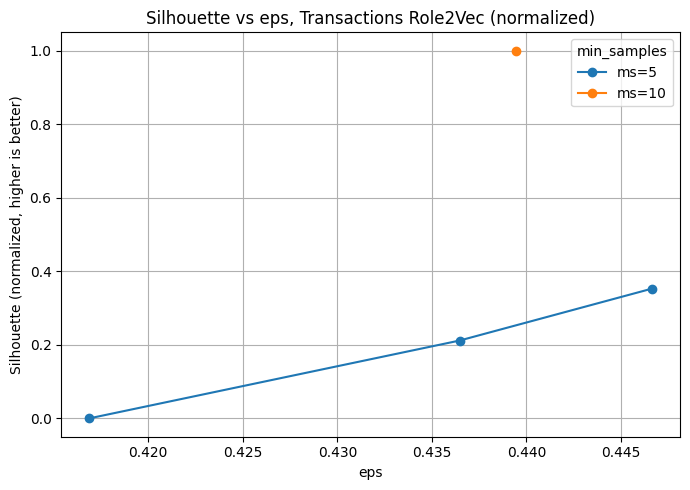

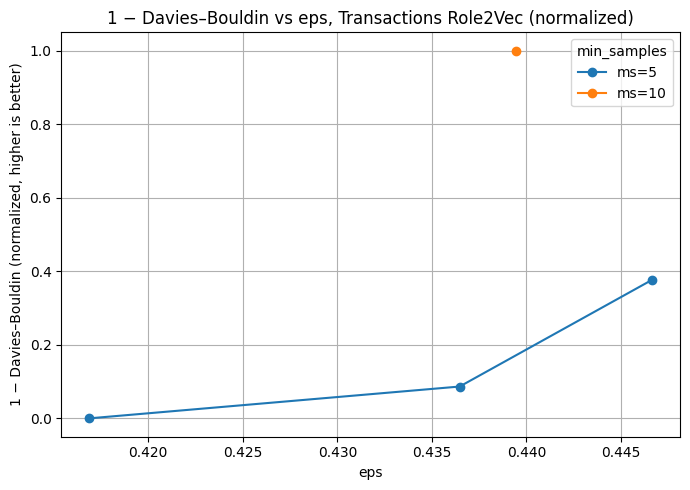

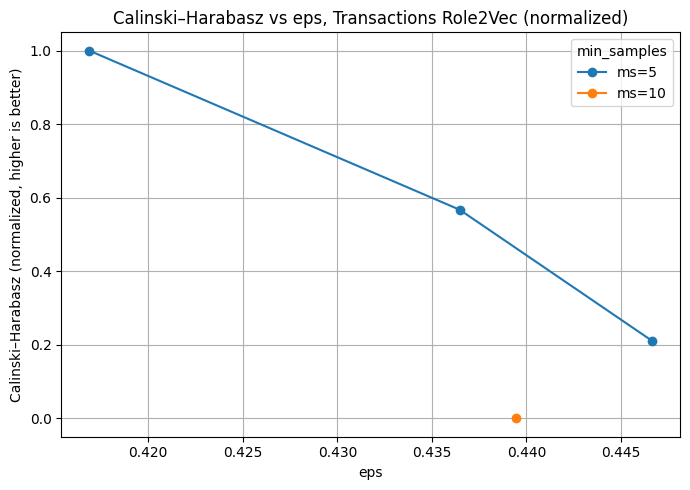

In [30]:
plot_metric("sil_norm",
            "Silhouette (normalized, higher is better)",
            "Silhouette vs eps, Transactions Role2Vec (normalized)")

plot_metric("dbi_norm",
            "1 − Davies–Bouldin (normalized, higher is better)",
            "1 − Davies–Bouldin vs eps, Transactions Role2Vec (normalized)")

plot_metric("ch_norm",
            "Calinski–Harabasz (normalized, higher is better)",
            "Calinski–Harabasz vs eps, Transactions Role2Vec (normalized)")

In [31]:
CORE_MIN = 500
COV_MIN, COV_MAX = 0.05, 0.80  

In [ ]:
feasible = intr[
    (intr["core_size"] >= CORE_MIN) &
    (intr["n_clusters"] >= 2) &
    (intr["coverage"].between(COV_MIN, COV_MAX)) &
    (~intr["silhouette_core"].isna())
].copy()

if feasible.empty:
    print("No feasible configs.")
else:
    ranked = feasible.sort_values(
        ["silhouette_core", "davies_bouldin_core", "calinski_harabasz_core", "coverage"],
        ascending=[False, True, False, False]
    ).reset_index(drop=True)

    best = ranked.iloc[0]
    cols_to_show = ["min_samples", eps_col, "core_size", "n_clusters",
                    "coverage", "silhouette_core", "davies_bouldin_core", "calinski_harabasz_core"]
    print("\nBest by intrinsic criteria:")
    print(best[cols_to_show])


No feasible configs by intrinsic criteria; relax thresholds or include extrinsic labels.


In [ ]:
def plot_internal_all(intr, title_prefix):
    eps_col = "eps_value" if "eps_value" in intr.columns else "eps"
    has_ms = "min_samples" in intr.columns and intr["min_samples"].notna().any()
    groups = intr.groupby("min_samples") if has_ms else [(None, intr)]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
    metrics = [
        ("sil_norm", "Silhouette (normalized)"),
        ("dbi_norm", "1 – Davies–Bouldin (normalized)"),
        ("ch_norm",  "Calinski–Harabasz (normalized)"),
    ]

    for ax, (mcol, ylabel) in zip(axes, metrics):

        for ms, df in groups:
            df = df.sort_values(eps_col)
            df = df[np.isfinite(df[eps_col]) & np.isfinite(df[mcol])]
            if df.empty:
                continue
            label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
            ax.plot(df[eps_col], df[mcol], marker="o", label=label, alpha=0.8)

        ax.set_xlabel("eps")
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

        metric_vals = intr[mcol].astype(float)
        mask = np.isfinite(intr[eps_col]) & np.isfinite(metric_vals)
        if mask.any():
            best_idx = metric_vals[mask].idxmax()
            best_row = intr.loc[best_idx]

            x_best = best_row[eps_col]
            y_best = best_row[mcol]
            ms_best = best_row["min_samples"] if "min_samples" in intr.columns else None

            if ms_best is not None and not np.isnan(ms_best):
                text = f"ms={int(ms_best)}, ε={x_best:.3f}"
            else:
                text = f"ε={x_best:.3f}"

            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xr = xmax - xmin
            yr = ymax - ymin

            tx = (x_best - xmin) / xr if xr != 0 else 0.5
            ty = (y_best - ymin) / yr if yr != 0 else 0.5

            if tx > 0.66:
                dx = -18
            elif tx < 0.33:
                dx = 18
            else:
                dx = 0

            if ty > 0.66:
                dy = -10
            elif ty < 0.33:
                dy = 10
            else:
                dy = 6 

            ax.annotate(
                text,
                xy=(x_best, y_best),
                xytext=(dx, dy),
                textcoords="offset points",
                ha="center",
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2",
                          fc="white", ec="none", alpha=0.7)
            )

    axes[0].set_title(f"{title_prefix} — Silhouette")
    axes[1].set_title(f"{title_prefix} — 1 − DB Index")
    axes[2].set_title(f"{title_prefix} — Calinski–Harabasz")

    if has_ms:
        axes[-1].legend(title="min_samples", bbox_to_anchor=(1.05, 1), loc="upper left")

    fig.suptitle(f"{title_prefix} — DBSCAN Internal Evaluation", y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


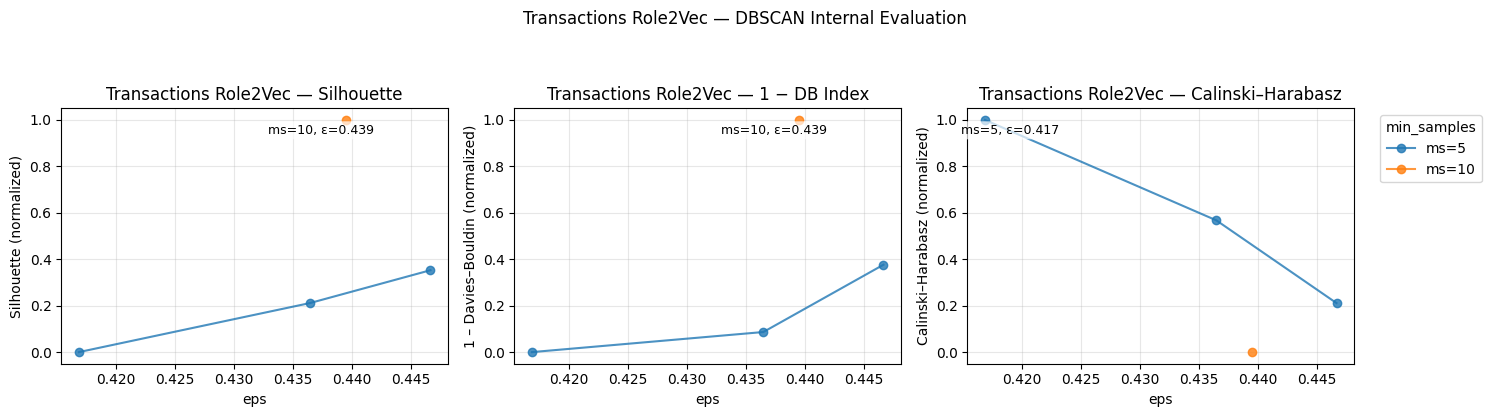

In [34]:
plot_internal_all(intr, title_prefix="Transactions Role2Vec")

Extrinsic

In [35]:
extr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_extrinsic_scores_kgrid_test.csv")

In [36]:
display(extr)

,label_col,min_samples,eps_value,core_size,coverage,n_clusters,ARI_masked,NMI_masked,Purity_masked,ARI_strict,NMI_strict
0,dbscan_ms5_p70_eps_0.416885,5,0.416885,387,0.974811,1,0.0,0.0,0.713178,-0.010657,0.026025
1,dbscan_ms5_p80_eps_0.436465,5,0.436465,393,0.989924,1,0.0,0.0,0.715013,-0.001451,0.018615
2,dbscan_ms5_p85_eps_0.446631,5,0.446631,394,0.992443,1,0.0,0.0,0.715736,0.002598,0.018775
3,dbscan_ms5_p90_eps_0.458462,5,0.458462,395,0.994962,1,0.0,0.0,0.716456,0.006701,0.019556
4,dbscan_ms5_p95_eps_0.473889,5,0.473889,396,0.997481,1,0.0,0.0,0.717172,0.010858,0.023245
5,dbscan_ms10_p70_eps_0.439453,10,0.439453,392,0.987406,1,0.0,0.0,0.714286,-0.005446,0.018750
6,dbscan_ms10_p80_eps_0.458728,10,0.458728,395,0.994962,1,0.0,0.0,0.716456,0.006701,0.019556
7,dbscan_ms10_p85_eps_0.468802,10,0.468802,396,0.997481,1,0.0,0.0,0.717172,0.010858,0.023245
8,dbscan_ms10_p90_eps_0.480132,10,0.480132,396,0.997481,1,0.0,0.0,0.717172,0.010858,0.023245
9,dbscan_ms10_p95_eps_0.495112,10,0.495112,397,1.000000,1,0.0,0.0,0.715365,0.000000,0.000000


-------------



stimation for the analysis -> ms=10 eps=0.468802 

-------------

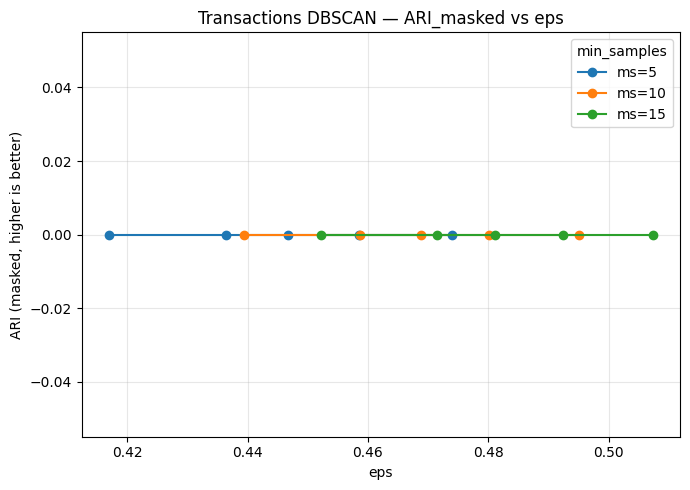

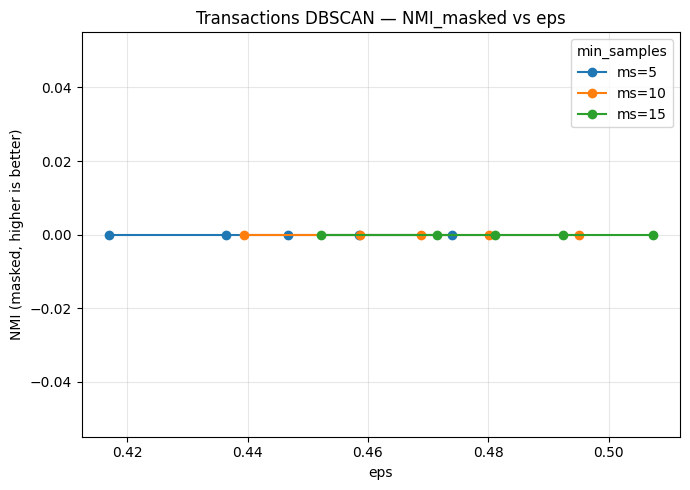

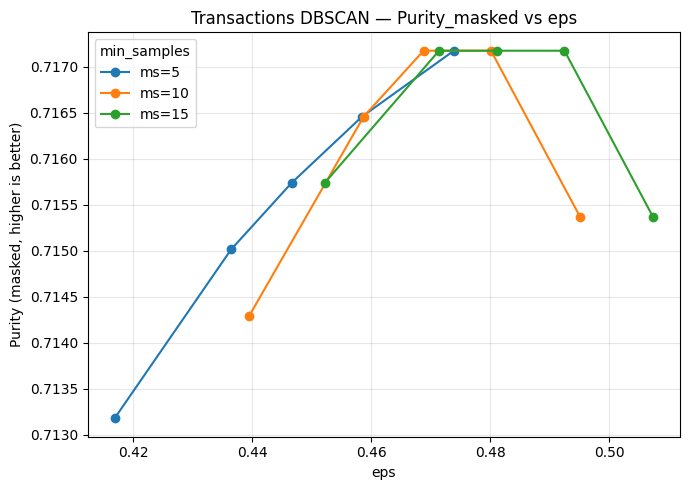

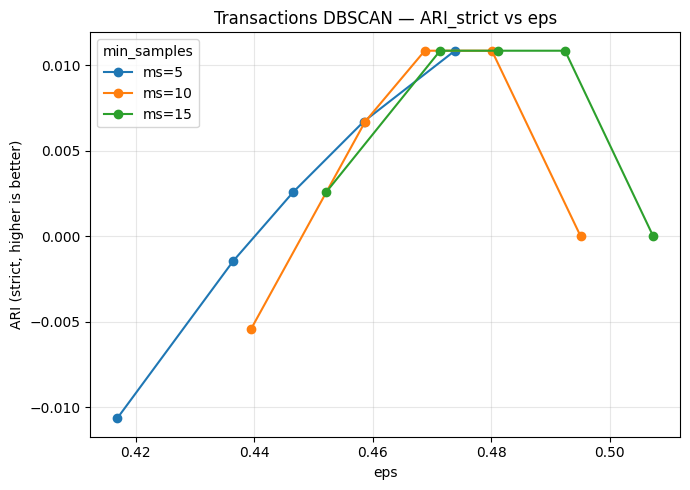

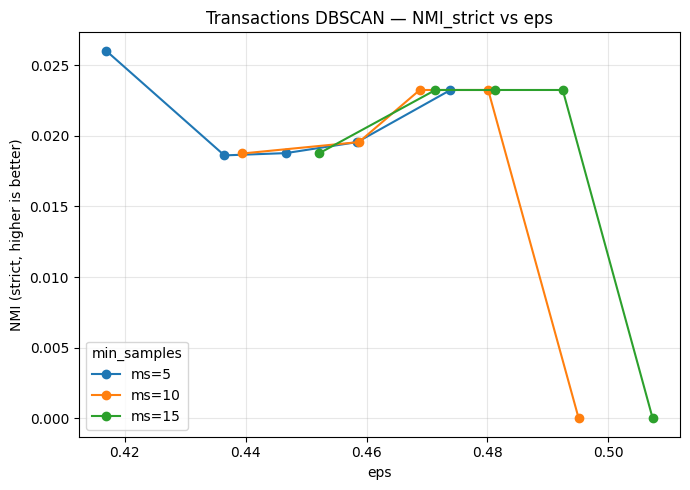

In [ ]:


extr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_extrinsic_scores_kgrid_test.csv")

eps_col = "eps_value" if "eps_value" in extr.columns else "eps"

has_ms = "min_samples" in extr.columns and extr["min_samples"].notna().any()
groups = extr.groupby("min_samples") if has_ms else [(None, extr)]

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both", alpha=0.3)
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

plot_metric("ARI_masked",
            "ARI (masked, higher is better)",
            "Transactions DBSCAN — ARI_masked vs eps")

plot_metric("NMI_masked",
            "NMI (masked, higher is better)",
            "Transactions DBSCAN — NMI_masked vs eps")

plot_metric("Purity_masked",
            "Purity (masked, higher is better)",
            "Transactions DBSCAN — Purity_masked vs eps")



plot_metric("ARI_strict",
            "ARI (strict, higher is better)",
            "Transactions DBSCAN — ARI_strict vs eps")

plot_metric("NMI_strict",
            "NMI (strict, higher is better)",
            "Transactions DBSCAN — NMI_strict vs eps")


In [ ]:
def plot_external_all(extr, title_prefix):
    eps_col = "eps_value" if "eps_value" in extr.columns else "eps"
    has_ms = "min_samples" in extr.columns and extr["min_samples"].notna().any()
    groups = extr.groupby("min_samples") if has_ms else [(None, extr)]

    fig = plt.figure(figsize=(18, 8))

    ax1 = plt.subplot(2, 3, 1)
    ax2 = plt.subplot(2, 3, 2)
    ax3 = plt.subplot(2, 3, 3)

    ax4 = plt.subplot(2, 3, 4)
    ax5 = plt.subplot(2, 3, 5)

    top_metrics = [
        (ax1, "ARI_masked",   "ARI (masked)"),
        (ax2, "NMI_masked",   "NMI (masked)"),
        (ax3, "Purity_masked","Purity (masked)"),
    ]

    bottom_metrics = [
        (ax4, "ARI_strict",   "ARI (strict)"),
        (ax5, "NMI_strict",   "NMI (strict)"),
    ]

    all_metrics = top_metrics + bottom_metrics

    for ax, mcol, ylabel in all_metrics:

        for ms, df in groups:
            df = df.sort_values(eps_col)
            df = df[np.isfinite(df[eps_col]) & np.isfinite(df[mcol])]
            if df.empty:
                continue
            label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
            ax.plot(df[eps_col], df[mcol], marker="o", label=label, alpha=0.8)

        ax.set_xlabel("eps")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title_prefix} — {ylabel}")
        ax.grid(True, alpha=0.3)

        metric_vals = extr[mcol].astype(float)
        mask = np.isfinite(extr[eps_col]) & np.isfinite(metric_vals)
        if mask.any():
            best_idx = metric_vals[mask].idxmax()
            best_row = extr.loc[best_idx]

            x_best = best_row[eps_col]
            y_best = best_row[mcol]
            ms_best = best_row["min_samples"] if "min_samples" in extr.columns else None

            if ms_best is not None and not np.isnan(ms_best):
                text = f"ms={int(ms_best)}, ε={x_best:.3f}"
            else:
                text = f"ε={x_best:.3f}"

           
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xr = xmax - xmin
            yr = ymax - ymin

          
            tx = (x_best - xmin) / xr if xr != 0 else 0.5
            ty = (y_best - ymin) / yr if yr != 0 else 0.5

            
            if tx > 0.66:
                dx = -20  
            elif tx < 0.33:
                dx = 20   
            else:
                dx = 0 

           
            if ty > 0.66:
                dy = -10 
            elif ty < 0.33:
                dy = 10 
            else:
                dy = 6 

            ax.annotate(
                text,
                xy=(x_best, y_best),
                xytext=(dx, dy),
                textcoords="offset points",
                ha="center",
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2",
                          fc="white", ec="none", alpha=0.7)
            )

    if has_ms:
        ax5.legend(title="min_samples", bbox_to_anchor=(1.05, 1), loc="upper left")

    fig.suptitle(f"{title_prefix} — DBSCAN External Evaluation", fontsize=14, y=0.97)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


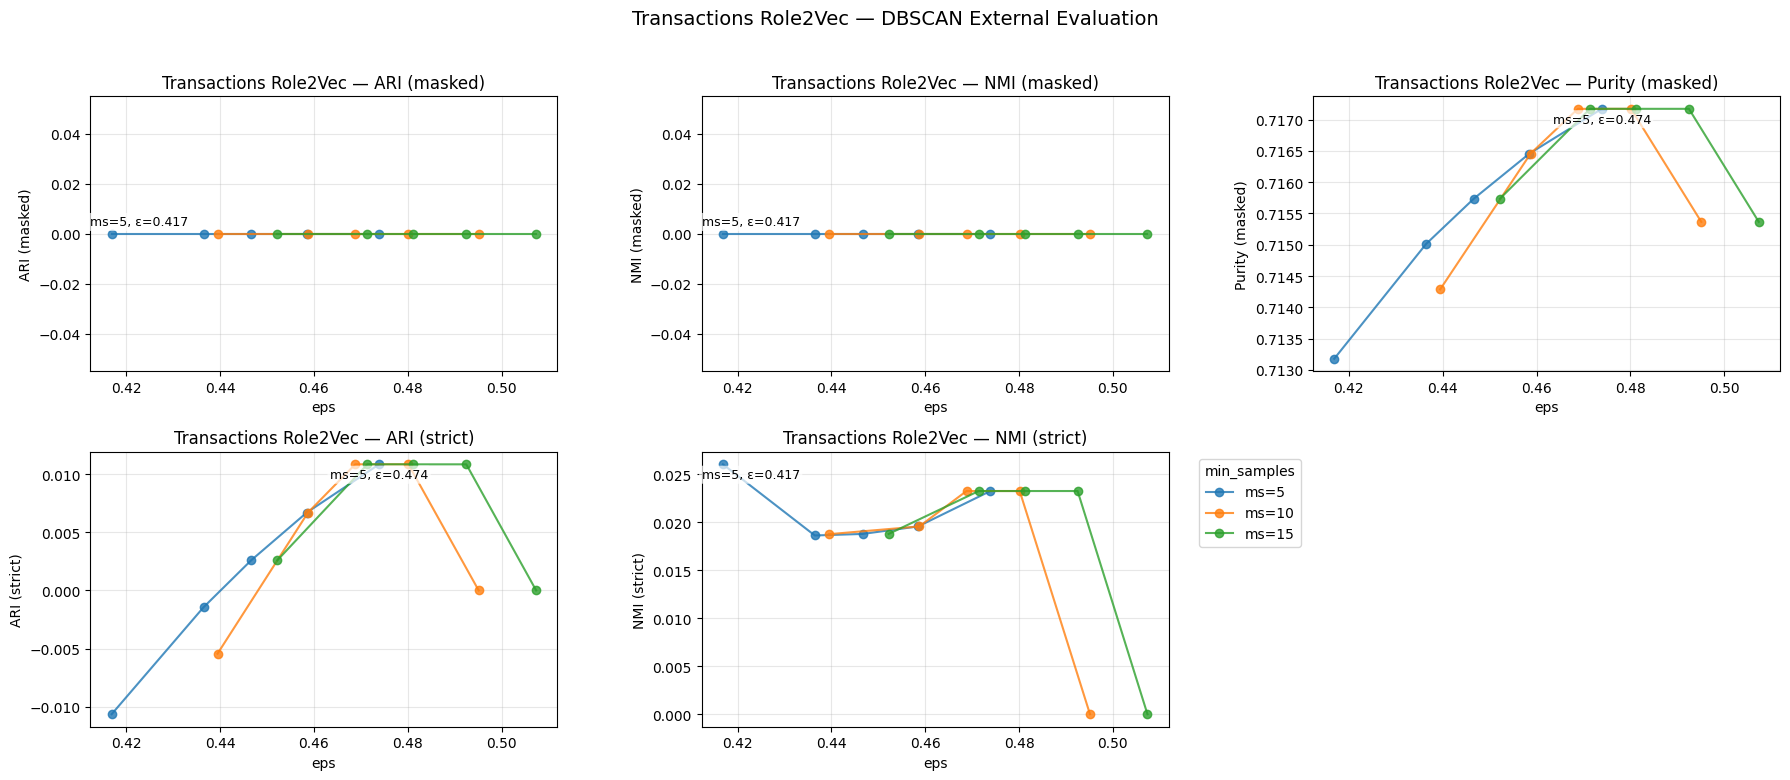

In [40]:
plot_external_all(extr, title_prefix="Transactions Role2Vec")

## Trustlines

Intrinsic

In [41]:
intr = pd.read_csv("trustlines/evaluation_res/trustlines_dbscan_intrinsic_scores_kgrid_test.csv")

In [42]:
display(intr)

,label_col,min_samples,eps_value,core_size,n_clusters,coverage,silhouette_core,davies_bouldin_core,calinski_harabasz_core
0,dbscan_ms5_p70_eps_0.290769,5,0.290769,20077,32,0.816603,-0.266173,1.675556,6.097574
1,dbscan_ms5_p80_eps_0.320623,5,0.320623,22016,15,0.895469,-0.210702,1.644999,4.518257
2,dbscan_ms5_p85_eps_0.340257,5,0.340257,22905,8,0.931628,-0.107953,1.608815,4.307967
3,dbscan_ms5_p90_eps_0.362472,5,0.362472,23651,5,0.961970,-0.072700,1.735964,4.173502
4,dbscan_ms5_p95_eps_0.395772,5,0.395772,24277,2,0.987432,0.069698,1.653265,2.603774
5,dbscan_ms10_p70_eps_0.321141,10,0.321141,21255,5,0.864516,-0.080890,1.829366,9.248337
6,dbscan_ms10_p80_eps_0.353638,10,0.353638,22949,2,0.933417,0.053723,1.811336,9.950821
7,dbscan_ms10_p85_eps_0.374160,10,0.374160,23623,1,0.960831,NaN,NaN,NaN
8,dbscan_ms10_p90_eps_0.398799,10,0.398799,24189,2,0.983853,0.079704,1.959687,5.763569
9,dbscan_ms10_p95_eps_0.432206,10,0.432206,24487,1,0.995973,NaN,NaN,NaN


In [43]:
eps_col = "eps_value" if "eps_value" in intr.columns else "eps"


has_ms = "min_samples" in intr.columns and intr["min_samples"].notna().any()
groups = intr.groupby("min_samples") if has_ms else [(None, intr)]

In [44]:
def minmax(x):
    x = x.astype(float)
    r = x.max() - x.min()
    return (x - x.min())/r if r != 0 else pd.Series(np.zeros_like(x), index=x.index)

intr["sil_norm"] = minmax(intr["silhouette_core"])
intr["dbi_norm"] = 1 - minmax(intr["davies_bouldin_core"])
intr["ch_norm"]  = minmax(intr["calinski_harabasz_core"])

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both")
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

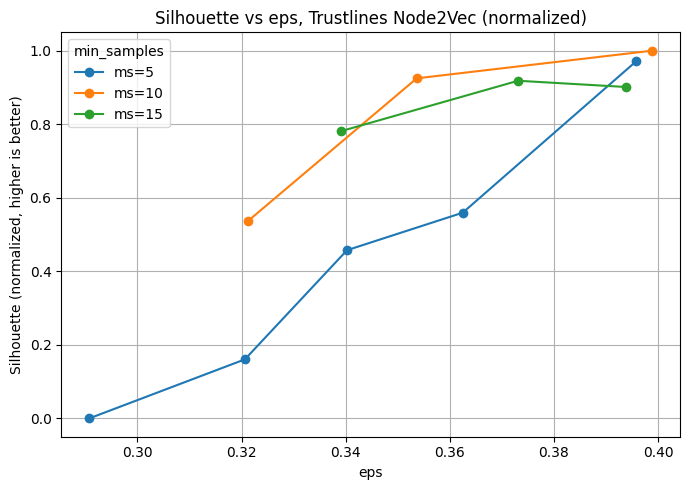

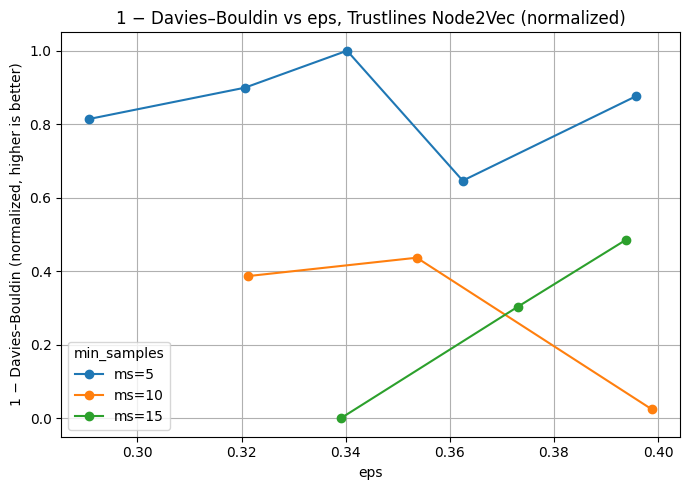

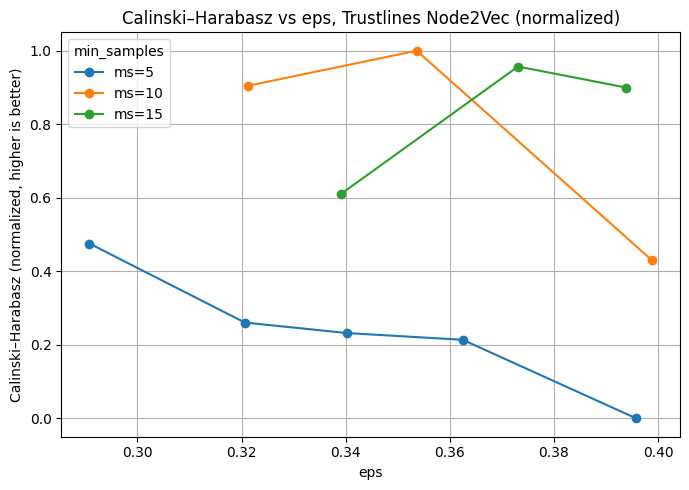

In [45]:
plot_metric("sil_norm",
            "Silhouette (normalized, higher is better)",
            "Silhouette vs eps, Trustlines Node2Vec (normalized)")

plot_metric("dbi_norm",
            "1 − Davies–Bouldin (normalized, higher is better)",
            "1 − Davies–Bouldin vs eps, Trustlines Node2Vec (normalized)")

plot_metric("ch_norm",
            "Calinski–Harabasz (normalized, higher is better)",
            "Calinski–Harabasz vs eps, Trustlines Node2Vec (normalized)")

In [46]:
CORE_MIN = 500
COV_MIN, COV_MAX = 0.05, 0.80  

In [ ]:
feasible = intr[
    (intr["core_size"] >= CORE_MIN) &
    (intr["n_clusters"] >= 2) &
    (intr["coverage"].between(COV_MIN, COV_MAX)) &
    (~intr["silhouette_core"].isna())
].copy()

if feasible.empty:
    print("No feasible configs.")
else:
    ranked = feasible.sort_values(
        ["silhouette_core", "davies_bouldin_core", "calinski_harabasz_core", "coverage"],
        ascending=[False, True, False, False]
    ).reset_index(drop=True)

    best = ranked.iloc[0]
    cols_to_show = ["min_samples", eps_col, "core_size", "n_clusters",
                    "coverage", "silhouette_core", "davies_bouldin_core", "calinski_harabasz_core"]
    print("\nBest by intrinsic criteria:")
    print(best[cols_to_show])


No feasible configs by intrinsic criteria; relax thresholds or include extrinsic labels.


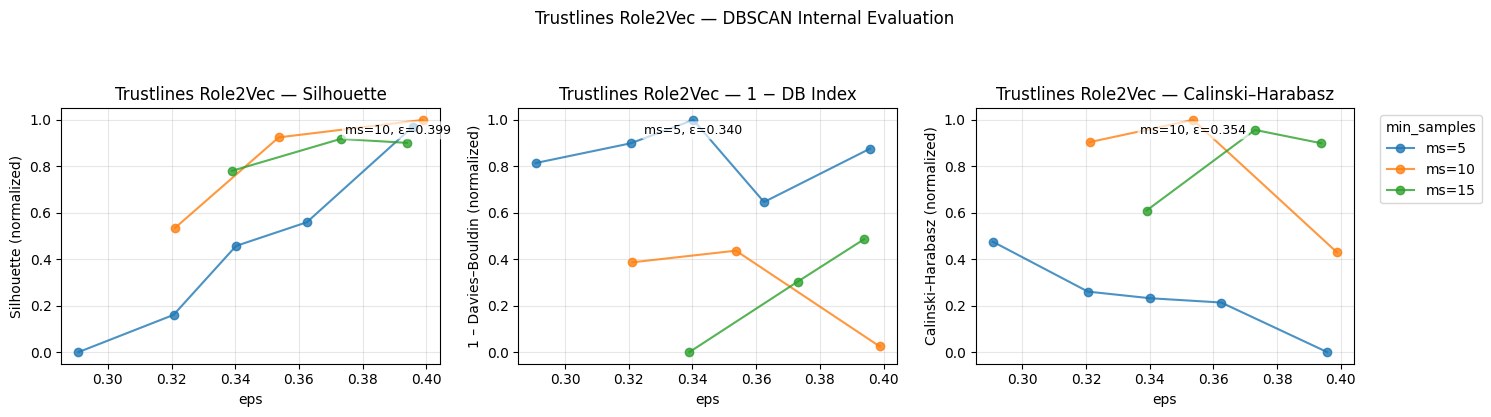

In [48]:
plot_internal_all(intr, title_prefix="Trustlines Role2Vec")

Extrinsic

In [49]:
extr = pd.read_csv("trustlines/evaluation_res/trustlines_dbscan_extrinsic_scores_kgrid_test.csv")

In [50]:
display(extr)

,label_col,min_samples,eps_value,core_size,coverage,n_clusters,ARI_masked,NMI_masked,Purity_masked,ARI_strict,NMI_strict
0,dbscan_ms5_p70_eps_0.290769,5,0.290769,115,0.827338,2,0.162848,0.197747,0.921739,0.260641,0.248690
1,dbscan_ms5_p80_eps_0.320623,5,0.320623,125,0.899281,2,0.235200,0.254323,0.904000,0.299912,0.286483
2,dbscan_ms5_p85_eps_0.340257,5,0.340257,131,0.942446,2,0.236666,0.254342,0.908397,0.423053,0.363221
3,dbscan_ms5_p90_eps_0.362472,5,0.362472,134,0.964029,2,0.190418,0.209814,0.888060,0.251151,0.250845
4,dbscan_ms5_p95_eps_0.395772,5,0.395772,137,0.985612,1,0.000000,0.000000,0.875912,0.070974,0.085027
5,dbscan_ms10_p70_eps_0.321141,10,0.321141,121,0.870504,1,0.000000,0.000000,0.917355,0.312563,0.230966
6,dbscan_ms10_p80_eps_0.353638,10,0.353638,128,0.920863,1,0.000000,0.000000,0.914062,0.391688,0.282601
7,dbscan_ms10_p85_eps_0.374160,10,0.374160,131,0.942446,1,0.000000,0.000000,0.900763,0.306273,0.233062
8,dbscan_ms10_p90_eps_0.398799,10,0.398799,138,0.992806,1,0.000000,0.000000,0.876812,0.087217,0.112472
9,dbscan_ms10_p95_eps_0.432206,10,0.432206,139,1.000000,1,0.000000,0.000000,0.870504,0.000000,0.000000


--------

selected ms=5, eps≈0.34

------

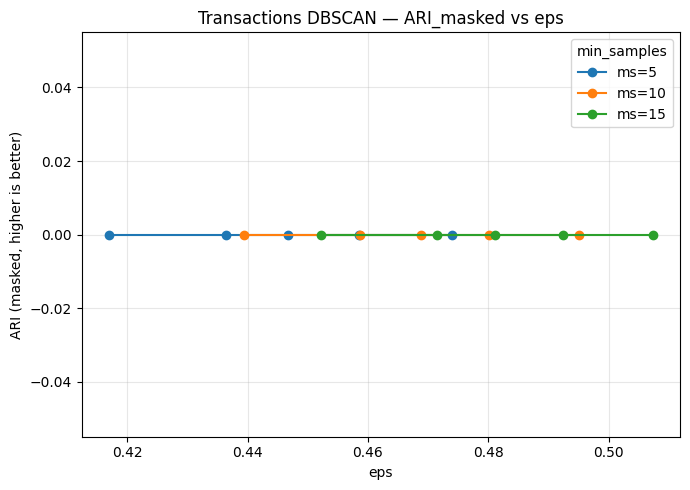

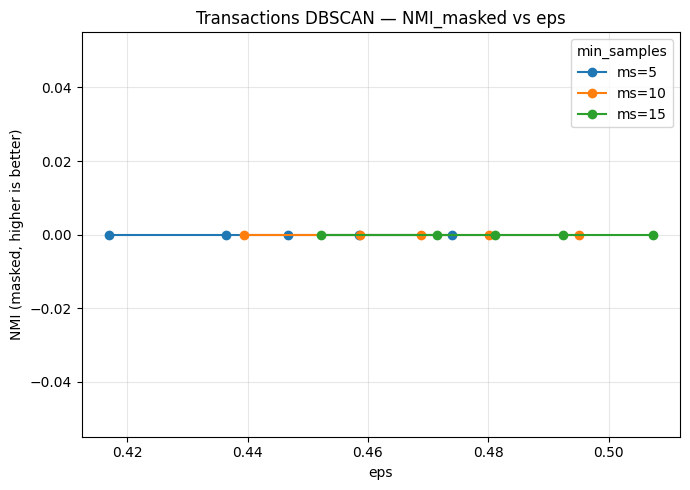

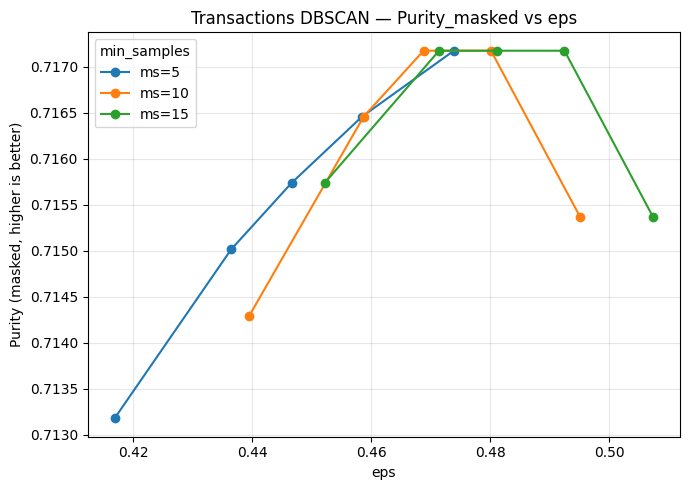

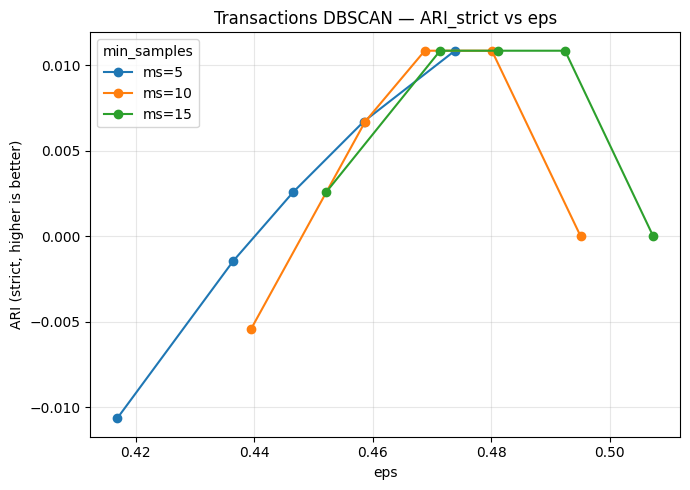

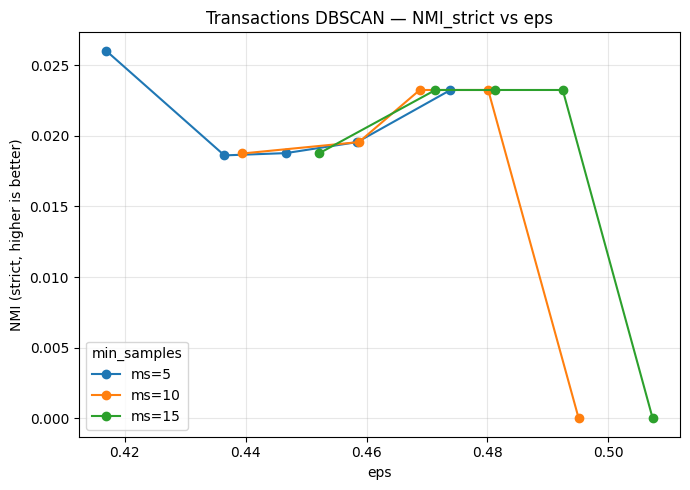

In [ ]:
extr = pd.read_csv("transactions/evaluation_res/transactions_dbscan_extrinsic_scores_kgrid_test.csv")

eps_col = "eps_value" if "eps_value" in extr.columns else "eps"

has_ms = "min_samples" in extr.columns and extr["min_samples"].notna().any()
groups = extr.groupby("min_samples") if has_ms else [(None, extr)]

def plot_metric(metric_col, ylabel, title):
    plt.figure(figsize=(7,5))
    for ms, df in groups:
        df = df.sort_values(eps_col)
        df = df[np.isfinite(df[eps_col]) & np.isfinite(df[metric_col])]
        if df.empty:
            continue
        label = f"ms={int(ms)}" if ms is not None and not np.isnan(ms) else None
        plt.plot(df[eps_col], df[metric_col], marker="o", label=label)
    plt.xlabel("eps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", axis="both", alpha=0.3)
    if has_ms:
        plt.legend(title="min_samples")
    plt.tight_layout()
    plt.show()

plot_metric("ARI_masked",
            "ARI (masked, higher is better)",
            "Transactions DBSCAN — ARI_masked vs eps")

plot_metric("NMI_masked",
            "NMI (masked, higher is better)",
            "Transactions DBSCAN — NMI_masked vs eps")

plot_metric("Purity_masked",
            "Purity (masked, higher is better)",
            "Transactions DBSCAN — Purity_masked vs eps")



plot_metric("ARI_strict",
            "ARI (strict, higher is better)",
            "Transactions DBSCAN — ARI_strict vs eps")

plot_metric("NMI_strict",
            "NMI (strict, higher is better)",
            "Transactions DBSCAN — NMI_strict vs eps")


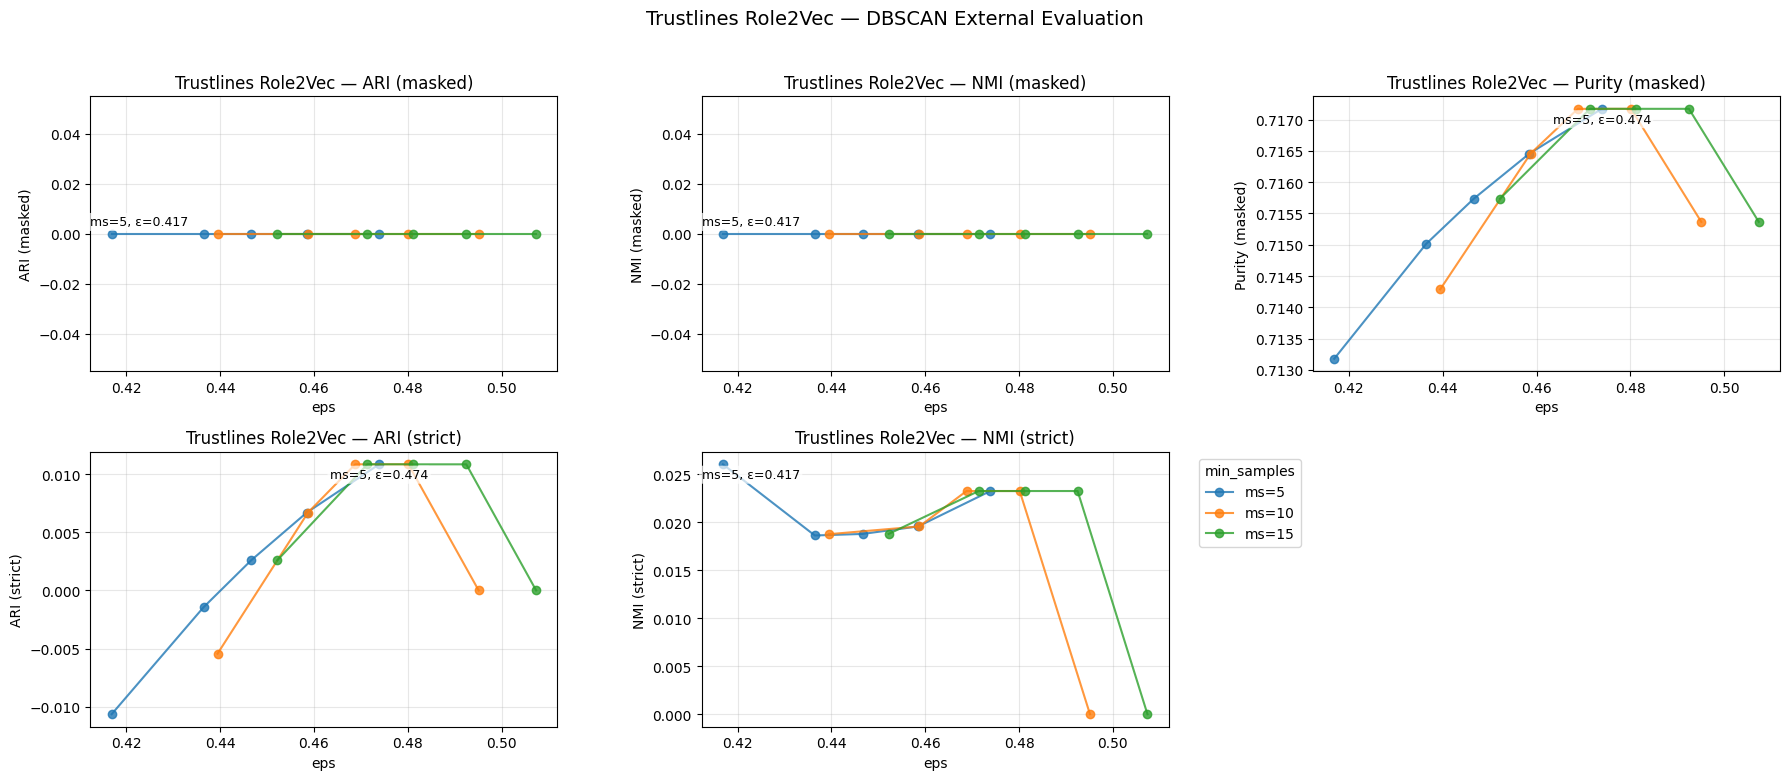

In [53]:
plot_external_all(extr, title_prefix="Trustlines Role2Vec")